In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from utils import read_log
from math import log, sqrt
from statistics import NormalDist

In [184]:
x = call_1.loc[335]
tte = 5 / 250 - (x['timestamp'] + x['day'] * 1_000_000) / 1_000_000 / 250
bs = BlackScholes(spot=x['spot'], strike=x['strike'], time_to_expiry=tte)
bs.implied_volatility(x['mid_price'])

64.98528630952023
4.319752311079355
0.007159595661505591
1.3642420526593924e-10
0.0


0.0409375

In [187]:
bs.call_price(0.1), x['mid_price']

(np.float64(686.5000189015409), np.float64(686.5))

In [197]:
class BlackScholes:
    def __init__(self, spot, strike, time_to_expiry):
        self.spot = spot
        self.strike = strike
        self.time_to_expiry = time_to_expiry

    def call_price(self, volatility):
        d1 = (
            log(self.spot) - log(self.strike) + (0.5 * volatility * volatility) * self.time_to_expiry
        ) / (volatility * sqrt(self.time_to_expiry))
        d2 = d1 - volatility * sqrt(self.time_to_expiry)
        call_price = self.spot * NormalDist().cdf(d1) - self.strike * NormalDist().cdf(d2)
        return call_price

    def delta(self, volatility):
        d1 = (
            log(self.spot) - log(self.strike) + (0.5 * volatility * volatility) * self.time_to_expiry
        ) / (volatility * sqrt(self.time_to_expiry))
        return NormalDist().cdf(d1)

    def gamma(self, volatility):
        d1 = (
            log(self.spot) - log(self.strike) + (0.5 * volatility * volatility) * self.time_to_expiry
        ) / (volatility * sqrt(self.time_to_expiry))
        return NormalDist().pdf(d1) / (self.spot * volatility * sqrt(self.time_to_expiry))

    def vega(self, volatility):
        d1 = (
            log(self.spot) - log(self.strike) + (0.5 * volatility * volatility) * self.time_to_expiry
        ) / (volatility * sqrt(self.time_to_expiry))
        return NormalDist().pdf(d1) * (self.spot * sqrt(self.time_to_expiry)) / 100

    def implied_volatility(self, market_call_price, max_iterations=200, tolerance=1e-10):
        low_vol = 0.01
        high_vol = 1.0
        volatility = (low_vol + high_vol) / 2.0  # Initial guess as the midpoint
        for _ in range(max_iterations):
            estimated_price = self.call_price(volatility)
            diff = estimated_price - market_call_price
            if abs(diff) < tolerance:
                break
            elif diff > 0:
                high_vol = volatility
            else:
                low_vol = volatility
            volatility = (low_vol + high_vol) / 2.0
        return volatility

In [347]:
def calc_time_to_expiry(day, ts):
    return (8 - day) / 250 - ts / 1_000_000 / 250

In [357]:
calc_time_to_expiry(3, 100_000)

0.0196

In [349]:
def calc_implied_vol(x):
    tte = calc_time_to_expiry(x['day'], x['timestamp'])
    bs = BlackScholes(spot=x['spot'], strike=x['strike'], time_to_expiry=tte)
    # return bs.implied_volatility(x['filtered_mid'])
    return bs.implied_volatility(x['mid_price'])

In [350]:
def calc_delta(x):
    tte = calc_time_to_expiry(x['day'], x['timestamp'])
    bs = BlackScholes(spot=x['spot'], strike=x['strike'], time_to_expiry=tte)
    return bs.delta(x['implied_vol'])

In [351]:
def calc_gamma(x):
    tte = calc_time_to_expiry(x['day'], x['timestamp'])
    bs = BlackScholes(spot=x['spot'], strike=x['strike'], time_to_expiry=tte)
    return bs.gamma(x['implied_vol'])

In [352]:
def calc_vega(x):
    tte = calc_time_to_expiry(x['day'], x['timestamp'])
    bs = BlackScholes(spot=x['spot'], strike=x['strike'], time_to_expiry=tte)
    return bs.vega(x['implied_vol'])

# Round 3

In [5]:
price_0 = pd.read_csv('../data/raw/round_3/prices_round_3_day_0.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_3/prices_round_3_day_1.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_3/prices_round_3_day_2.csv', delimiter=';')

In [6]:
trades_0 = pd.read_csv('../data/raw/round_3/trades_round_3_day_0.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_3/trades_round_3_day_1.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_3/trades_round_3_day_2.csv', delimiter=';')

In [7]:
prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

In [371]:
rock = prices[prices['product'] == 'VOLCANIC_ROCK'].reset_index(drop=True)
call_0 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_9500'].reset_index(drop=True)
call_1 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_9750'].reset_index(drop=True)
call_2 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_10000'].reset_index(drop=True)
call_3 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_10250'].reset_index(drop=True)
call_4 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_10500'].reset_index(drop=True)

call_0 = call_0.assign(strike=9500)
call_1 = call_1.assign(strike=9750)
call_2 = call_2.assign(strike=10000)
call_3 = call_3.assign(strike=10250)
call_4 = call_4.assign(strike=10500)

calls = [call_0, call_1, call_2, call_3, call_4]
for call in calls:
    call['spot'] = rock['mid_price']
    call['intrinsic'] = np.max([call['spot'] - call['strike'], np.zeros(call.shape[0])], axis=0)
    call['filtered_mid'] = call.apply(lambda x: x['intrinsic'] if x['mid_price'] < x['intrinsic'] else x['mid_price'], axis=1)
    call['implied_vol'] = call.apply(calc_implied_vol, axis=1)

    # call['vega'] = call.apply(calc_vega, axis=1)
    # call['implied_vol'] = call.apply(lambda x: x['implied_vol'] if x['vega'] > 1e-6 else None, axis=1)  # filter 0 vega
    
    call['delta'] = call.apply(calc_delta, axis=1)
    call['gamma'] = call.apply(calc_gamma, axis=1)
    call['vega'] = call.apply(calc_vega, axis=1)

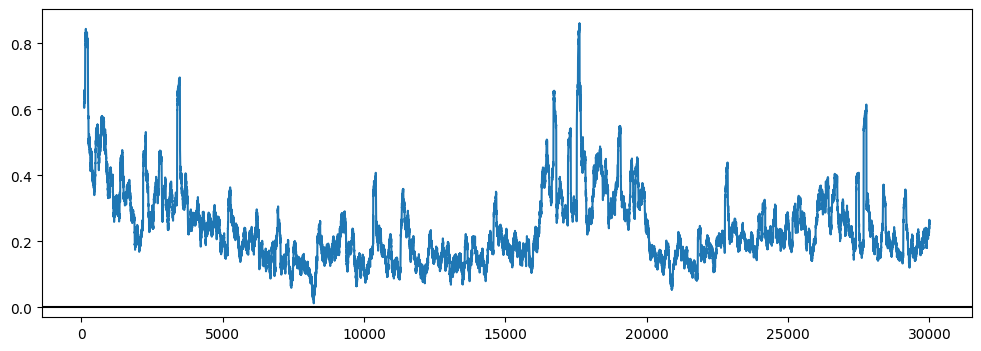

In [372]:
logr = np.log(rock['mid_price'] / rock['mid_price'].shift(1))
realized_vol = logr.rolling(100).std() * np.sqrt(10000 * 250)

plt.figure(figsize=(12, 4))
plt.plot(realized_vol - call_2['implied_vol'])
plt.axhline(0, c='k')
plt.show()

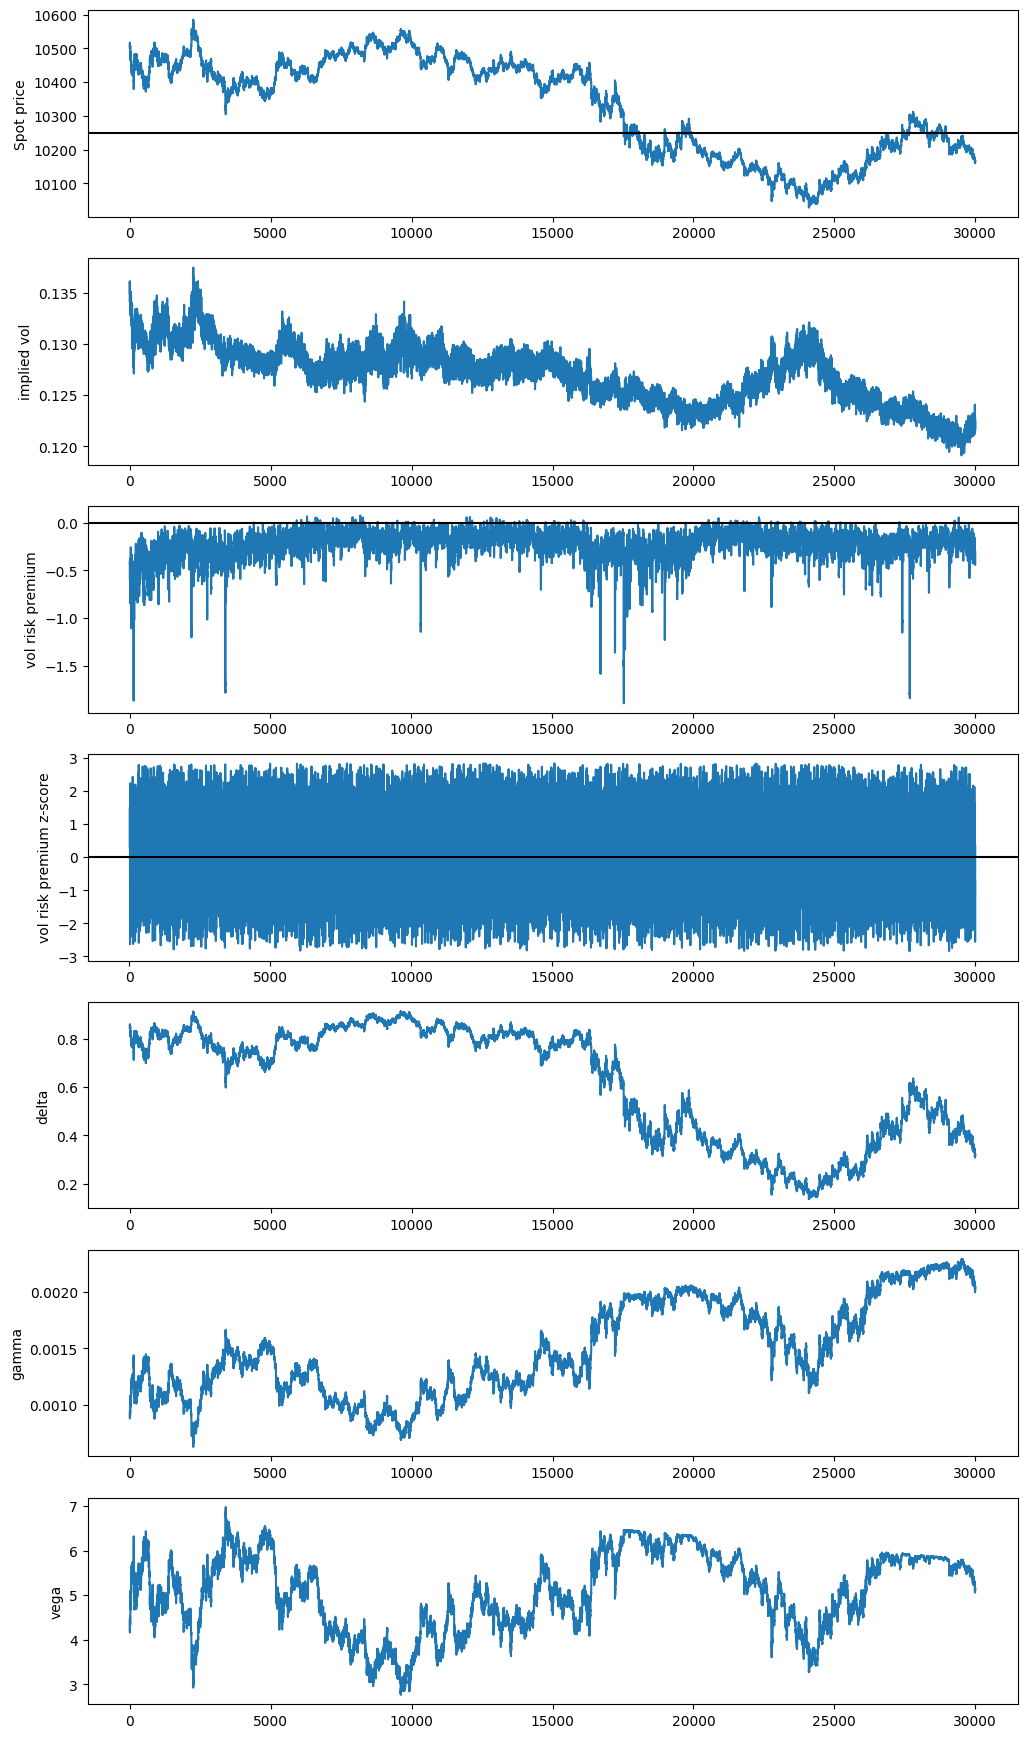

In [397]:
call = call_3
w = 10

logr = np.log(rock['mid_price'] / rock['mid_price'].shift(1))
realized_vol = logr.rolling(w).std() * np.sqrt(10000 * 250)
vol_spread = call['implied_vol'] - realized_vol
vol_spread_zscore = (vol_spread - vol_spread.rolling(w).mean()) / vol_spread.rolling(w).std()

fig, ax = plt.subplots(7, 1, figsize=(12, 22))
ax[0].plot(call['spot'])
ax[0].set_ylabel('Spot price')
ax[0].axhline(call.iloc[0]['strike'], c='k')
ax[1].plot(call['implied_vol'])
ax[1].set_ylabel('implied vol')
ax[2].plot(vol_spread)
ax[2].axhline(0, c='k')
ax[2].set_ylabel('vol risk premium')
ax[3].plot(vol_spread_zscore)
ax[3].axhline(0, c='k')
ax[3].set_ylabel('vol risk premium z-score')
ax[4].plot(call['delta'])
ax[4].set_ylabel('delta')
ax[5].plot(call['gamma'])
ax[5].set_ylabel('gamma')
ax[6].plot(call['vega'])
ax[6].set_ylabel('vega')
plt.show()

In [210]:
products = [rock, call_0, call_1, call_2, call_3, call_4]

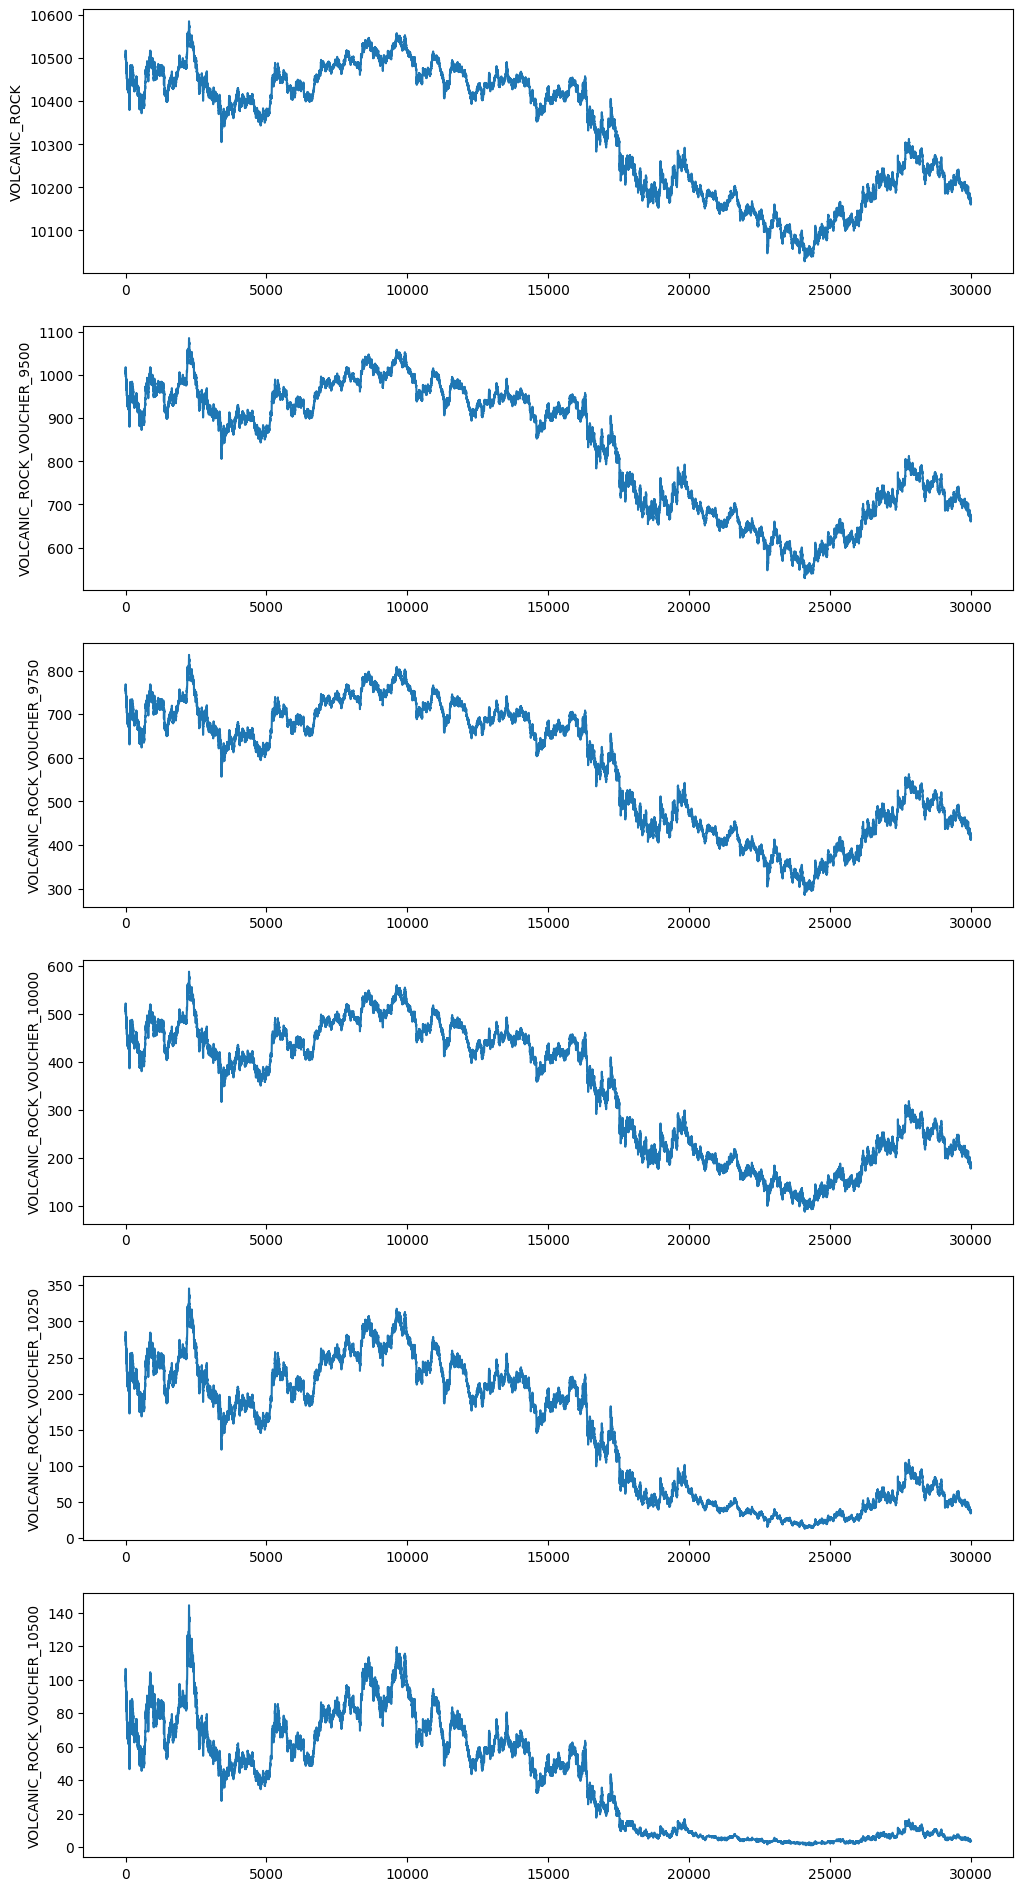

In [211]:
fig, ax = plt.subplots(6, 1, figsize=(12, 24))
for i, prod in enumerate(products):
    ax[i].plot(prod['mid_price'])
    ax[i].set_ylabel(prod['product'].iloc[0])
plt.show()

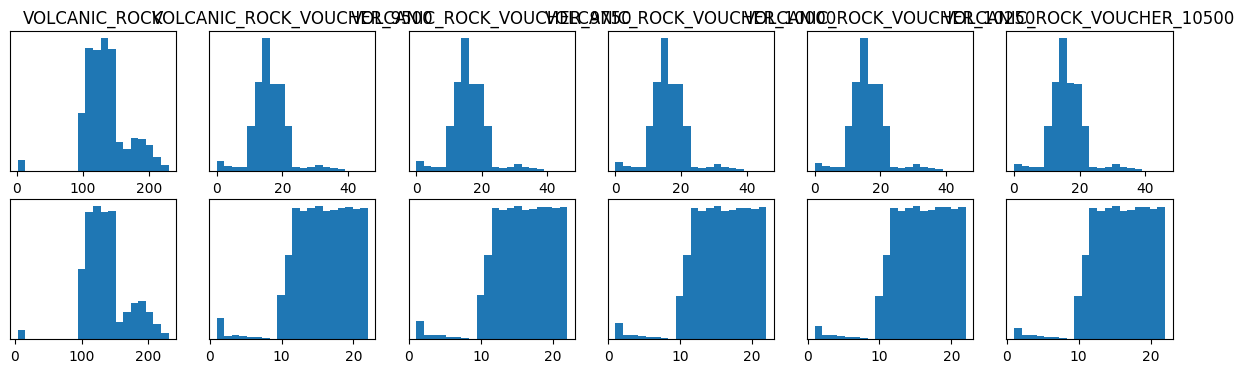

In [163]:
fig, ax = plt.subplots(2, 6, figsize=(15, 4))
for i, prod in enumerate(products):
    ax[0, i].hist(prod['bid_volume_1'], bins=20)
    ax[1, i].hist(prod['ask_volume_1'], bins=20)
    ax[0, i].set_title(prod.iloc[0]['product'])
    ax[0, i].set_yticks([])
    ax[1, i].set_yticks([])
plt.show()

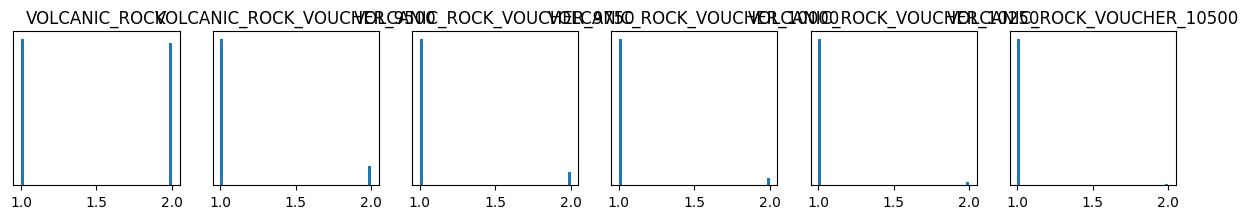

In [164]:
fig, ax = plt.subplots(1, 6, figsize=(15, 2))
for i, prod in enumerate(products):
    ax[i].hist(prod['ask_price_1'] - prod['bid_price_1'], bins=50)
    ax[i].set_title(prod.iloc[0]['product'])
    ax[i].set_yticks([])
plt.show()

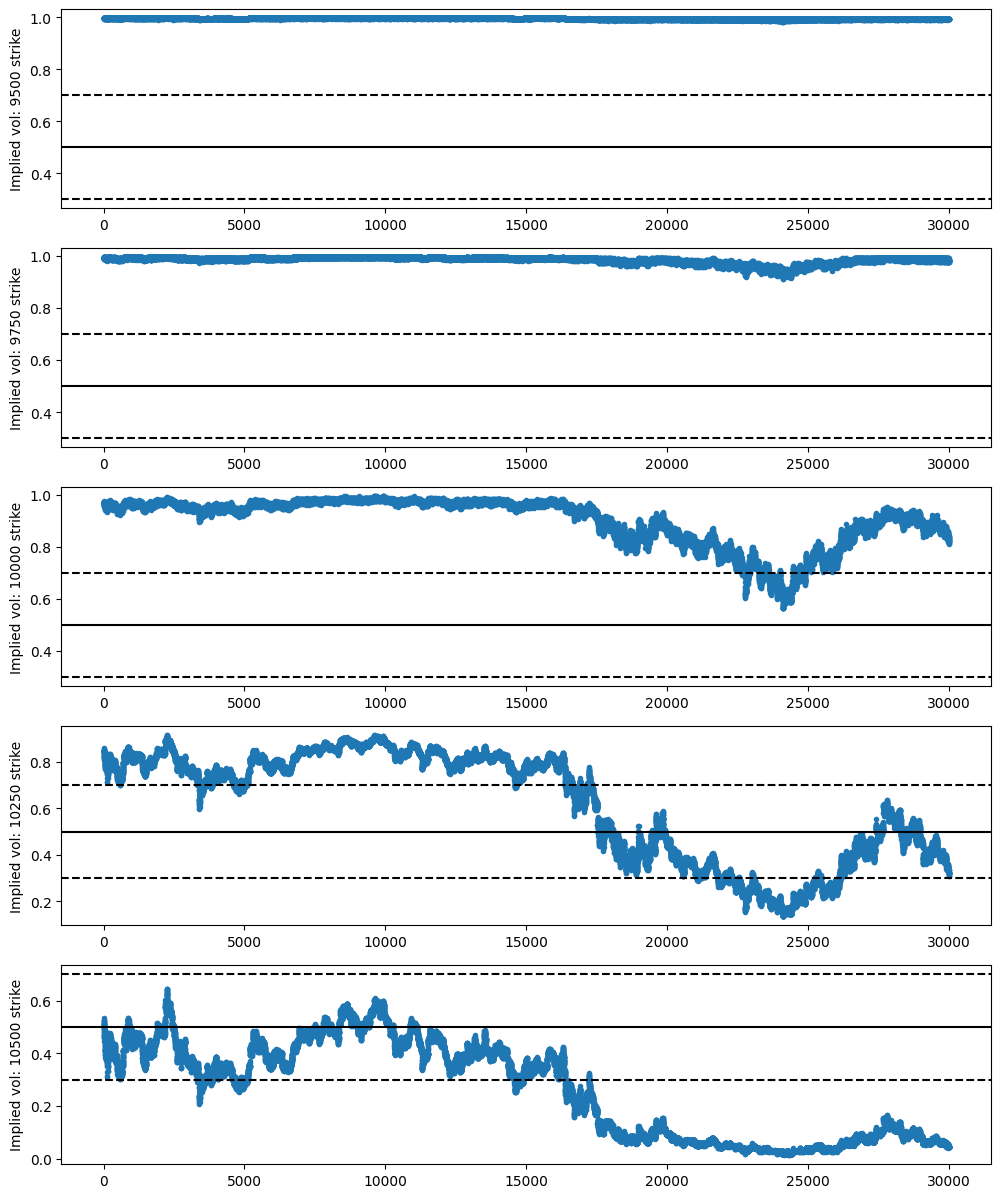

In [335]:
fig, ax = plt.subplots(5, 1, figsize=(12, 15))
for i, call in enumerate([call_0, call_1, call_2, call_3, call_4]):
    ax[i].scatter(np.arange(len(call)), call['delta'], marker='.')
    ax[i].set_ylabel(f'Implied vol: {call.iloc[0]['strike']} strike')
    ax[i].axhline(0.5, c='k')
    ax[i].axhline(0.3, c='k', linestyle='dashed')
    ax[i].axhline(0.7, c='k', linestyle='dashed')
plt.show()

In [172]:
call_0[call_0['implied_vol'] <= 0.1]['implied_vol']

8        0.071875
9        0.071875
14       0.071875
15       0.071875
18       0.071875
           ...   
29991    0.071875
29994    0.071875
29995    0.071875
29998    0.071875
29999    0.071875
Name: implied_vol, Length: 12578, dtype: float64

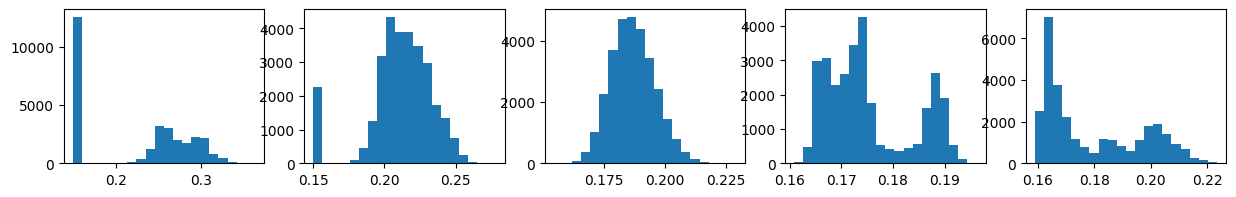

In [130]:
fig, ax = plt.subplots(1, 5, figsize=(15, 2))
for i, call in enumerate([call_0, call_1, call_2, call_3, call_4]):
    ax[i].hist(call['implied_vol'], bins=20)
plt.show()

In [10]:
# for prod in products:
#     logr = np.log(prod['mid_price']) - np.log(prod['mid_price'].shift(1))
#     logr = logr.dropna()
#     fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#     plot_acf(logr, ax=ax[0], zero=False)
#     plot_pacf(logr, ax=ax[1], zero=False)
#     ax[0].set_xlim([0, 15])
#     ax[1].set_xlim([0, 15])
#     ax[0].set_ylabel(prod.iloc[0]['product'])
#     plt.show()